PPP (with DnCNN) Image Deconvolution (Proximal ADMM Solver)
===========================================================

This example demonstrates the solution of an image deconvolution problem
using a proximal ADMM variant of the Plug-and-Play Priors (PPP) algorithm
<cite data-cite="venkatakrishnan-2013-plugandplay2"/> with the DnCNN
<cite data-cite="zhang-2017-dncnn"/> denoiser.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.optimize import ProximalADMM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = snp.array(x_gt)  # convert to jax array

Set up forward operator $A$ and test signal consisting of blurred signal with
additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = random.randn(Ax.shape)
y = Ax + σ * noise

Set up the problem to be solved. We want to minimize the functional

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + R(\mathbf{x}) \;$$

where $R(\cdot)$ is a pseudo-functional having the DnCNN denoiser as its
proximal operator. A slightly unusual variable splitting is used,\
including setting the $f$ functional to the $R(\cdot)$ term and the $g$
functional to the data fidelity term to allow the use of proximal ADMM,
which avoids the need for conjugate gradient sub-iterations in the solver
steps.

In [4]:
f = functional.DnCNN(variant="17M")
g = loss.SquaredL2Loss(y=y)

Set up proximal ADMM solver.

In [5]:
ρ = 0.2  # ADMM penalty parameter
maxiter = 10  # number of proximal ADMM iterations
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    rho=ρ,
    mu=mu,
    nu=nu,
    x0=A.T @ y,
    maxiter=maxiter,
    itstat_options={"display": True},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl
------------------------------------
   0  1.87e+00  4.320e+01  2.631e+02


   1  2.09e+00  2.946e+01  5.875e+00


   2  2.29e+00  2.433e+01  4.868e+00


   3  2.49e+00  2.039e+01  4.079e+00


   4  2.69e+00  1.701e+01  3.403e+00


   5  2.90e+00  1.412e+01  2.825e+00


   6  3.10e+00  1.172e+01  2.345e+00


   7  3.30e+00  9.744e+00  1.950e+00


   8  3.50e+00  8.121e+00  1.625e+00
   9  3.70e+00  6.782e+00  1.357e+00


Show the recovered image.

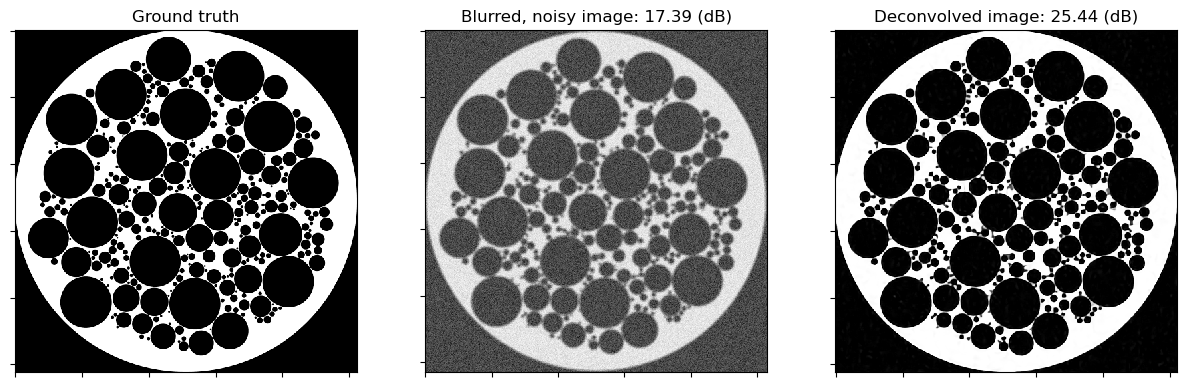

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = snp.clip(y[nc:-nc, nc:-nc], 0, 1)
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

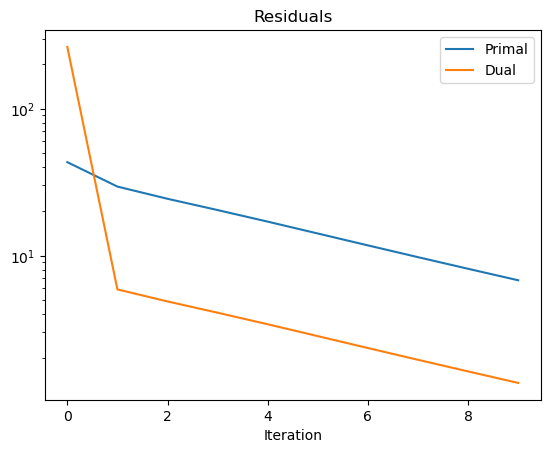

In [8]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)